In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from utils import save_fig_for_raport, dataframe_to_latex_tabular 
from pandas.plotting import autocorrelation_plot
import pandas.plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.consts import TimeSesData
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector

In [2]:
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_all_2022_04_26_filtered.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

,hits,date


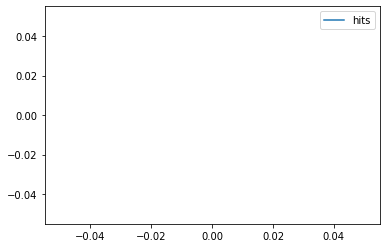

In [3]:
raw_data.loc[raw_data["cat_id"] == 11037][["hits"]].plot()
raw_data.loc[raw_data["cat_id"] == 11037][["hits", "date"]]

In [4]:
categories = pd.read_csv("../datasets/raw/solr_categories_all_2022_02_14.csv")
# Join market_insight table with category names
category_names = categories[[ "internal_doc_id", "title"]]
category_id_to_names_map = dict(map(lambda x: (x["internal_doc_id"], x["title"]), category_names.to_dict("records")))
category_name_to_id_map = dict(map(lambda x: (x["title"], x["internal_doc_id"]), category_names.to_dict("records")))

In [5]:

data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).sum()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]

# Join with category names
data_grouped = pd.merge(data_grouped , category_names, how="left", left_on=["cat_id"], right_on=["internal_doc_id"])
data_grouped.rename(columns={"title": "cat_name"}, inplace=True)
data_grouped.drop(columns=["internal_doc_id"], inplace=True, axis=1)

data_chosen_categories = data_grouped[["interest", "date", "cat_id", "cat_name"]]
data = data_chosen_categories

<AxesSubplot:>

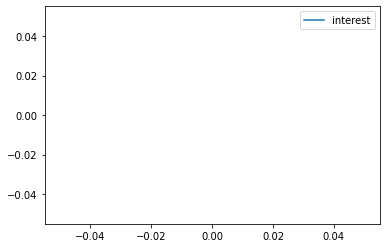

In [6]:
data.loc[data["cat_id"] == 11037][["interest"]].plot()

In [7]:
# Fill in all missing days
#data_grouped_filled_dates = data_chosen_categories.groupby(pd.Grouper(key="date", freq='D')).sum()

#data = data_grouped_filled_dates
#data.head()

In [8]:
# Pivot table by cat_id
data_by_cat_id = data.pivot(index=["date"], columns=["cat_id", "cat_name"])["interest"]
data_by_cat_id.head()

cat_id,2,6,9,10,11,13,20,22,24,26,...,11850,11852,11866,11950,11998,12197,12256,12322,12502,12532
cat_name,Bærbar PC,Digitalkamera,Harddisk og SSD,Hovedkort,PC-høyttaler,Kabinett,MP3-spiller,Mus,Objektiv,Projektor,...,Langrennski,Skisko,Klister,Garasjetelt,Hjertestarter,Mosefjerner og plenlufter,Terrassebord,Vinterjakke,Stikk og bitt,SUP - Stand Up Paddle
date,,,,,,,,,,,,,,,,,,,,,
2018-12-02,2751.0,468.0,873.0,620.0,173.0,502.0,72.0,692.0,648.0,261.0,...,523.0,180.0,46.0,6.0,10.0,NaN,NaN,NaN,NaN,NaN
2018-12-03,3307.0,519.0,918.0,668.0,151.0,618.0,70.0,790.0,536.0,401.0,...,543.0,189.0,38.0,1.0,11.0,NaN,NaN,NaN,NaN,NaN
2018-12-04,3461.0,581.0,947.0,600.0,157.0,523.0,62.0,731.0,573.0,282.0,...,475.0,233.0,43.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN
2018-12-05,3158.0,451.0,1106.0,582.0,145.0,553.0,58.0,632.0,484.0,232.0,...,358.0,197.0,35.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN
2018-12-06,3245.0,432.0,1078.0,559.0,108.0,444.0,54.0,622.0,505.0,342.0,...,601.0,200.0,40.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [9]:
corr_categories = [2, 6, 9, 10, 11, 13, 20]

seasonal_categories_cat_name =["Vinterjakke",
"Vintersko",
"Langrennski",
"Skisko",
"Varmeovn",
"Snøfreser",
"Snøskuffe",]

seasonal_categories = list(map(lambda x: category_name_to_id_map[x], seasonal_categories_cat_name))
seasonal_categories

[12322, 11428, 11850, 11852, 273, 11036, 11213]

## Decompose time series
We can decompose each series in into its trend, seasonality and residuals (rest).
Then we can use the dicky-fuller test on the residuals to check if the series is stationary.
If the p-value is < 0.05 it is stationary.
Results: The risiduals are mostly stationary

In [10]:
nettverkskabler = data_grouped.loc[data["cat_id"] ==  2]
        
#nettverkskabler['date'] =  pd.to_datetime(raw_data['date'])
nettverkskabler = nettverkskabler.rename(columns={"date": "time"})
ts = TimeSeriesData(nettverkskabler[["time", "interest"]])

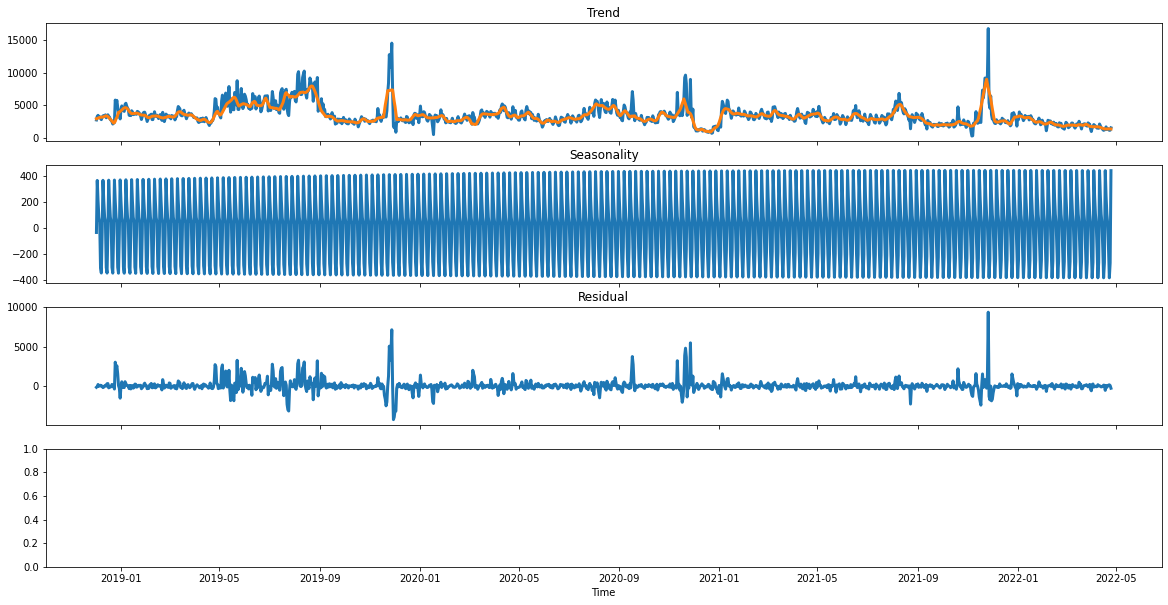

In [11]:
decomposer = TimeSeriesDecomposition(ts, decomposition="additive", robust=True, seasonal=365)
results = decomposer.decomposer()
fig = decomposer.plot()

,time,trend
0,2019-03-12,3944.301691
1,2019-03-13,4001.835881
2,2019-03-14,4024.018937
3,2019-03-15,3981.009812
4,2019-03-16,3863.845822
5,2019-03-17,3760.021999
6,2019-03-18,3672.949060


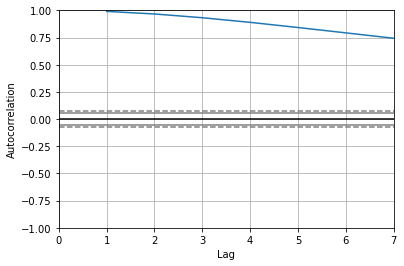

In [12]:
from pandas.plotting import autocorrelation_plot
trend = results["trend"].to_dataframe()
trend.set_index("time", inplace=True)
autocorrelation_plot(trend, ).set_xlim(0, 7)
results["trend"][100:100+7]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

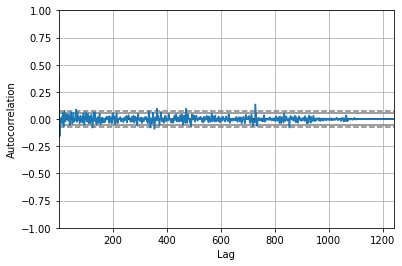

In [13]:

from pandas.plotting import autocorrelation_plot
trend = results["rem"].to_dataframe()
trend.set_index("time", inplace=True) 
autocorrelation_plot(trend, )

<AxesSubplot:xlabel='time'>

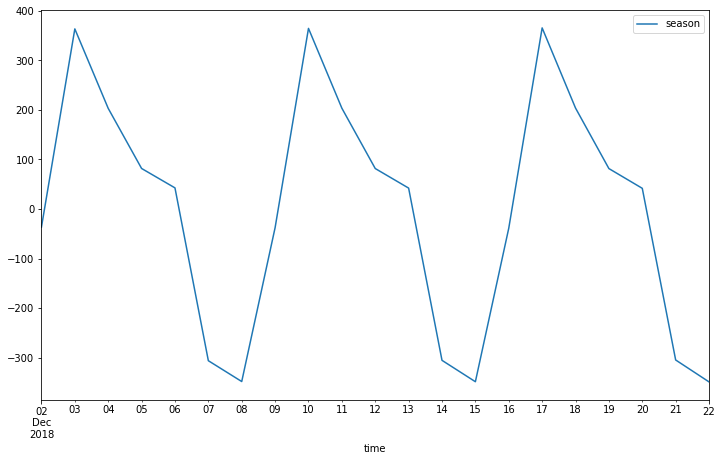

In [125]:
results["seasonal"][:7*3].plot()

In [126]:
# Detect seasonality
fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

In [127]:
outlier_detector = OutlierDetector(ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('2019-05-13 00:00:00'),
 Timestamp('2019-05-23 00:00:00'),
 Timestamp('2019-05-28 00:00:00'),
 Timestamp('2019-07-22 00:00:00'),
 Timestamp('2019-08-05 00:00:00'),
 Timestamp('2019-08-06 00:00:00'),
 Timestamp('2019-08-13 00:00:00'),
 Timestamp('2019-08-29 00:00:00'),
 Timestamp('2019-11-25 00:00:00'),
 Timestamp('2019-11-28 00:00:00'),
 Timestamp('2019-11-30 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-09-17 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2020-11-20 00:00:00'),
 Timestamp('2020-11-21 00:00:00'),
 Timestamp('2020-11-23 00:00:00'),
 Timestamp('2020-11-27 00:00:00'),
 Timestamp('2021-11-26 00:00:00'),
 Timestamp('2021-11-27 00:00:00'),
 Timestamp('2021-11-28 00:00:00')]

<AxesSubplot:xlabel='time'>

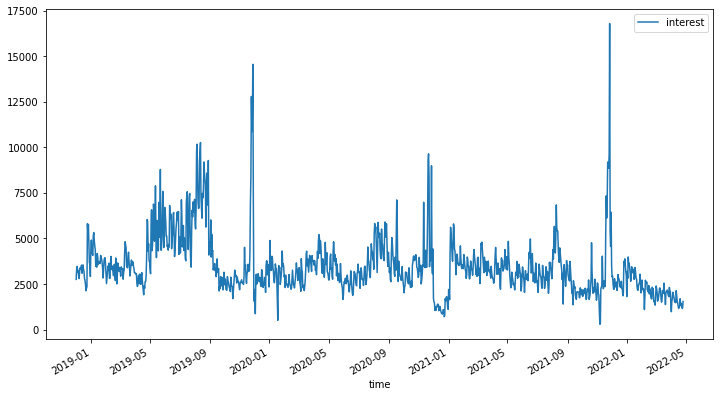

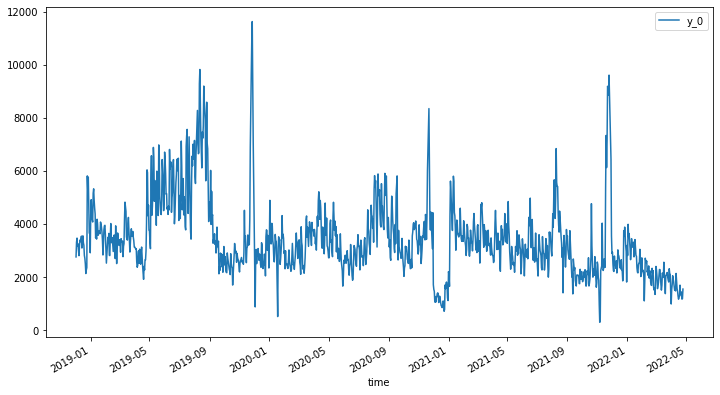

In [128]:
ts_outliers_interpolated = outlier_detector.remover(interpolate=True)
ts.plot()
ts_outliers_interpolated.plot()

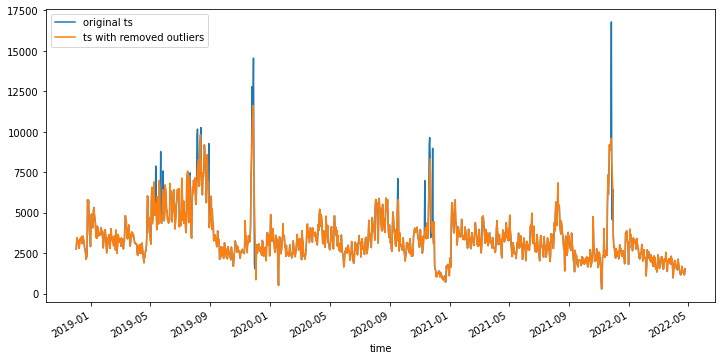

In [129]:
ax = ts.to_dataframe().plot(x="time", y="interest", figsize=(12, 6))
ts_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
plt.legend(labels=["original ts", "ts with removed outliers"])
plt.show()

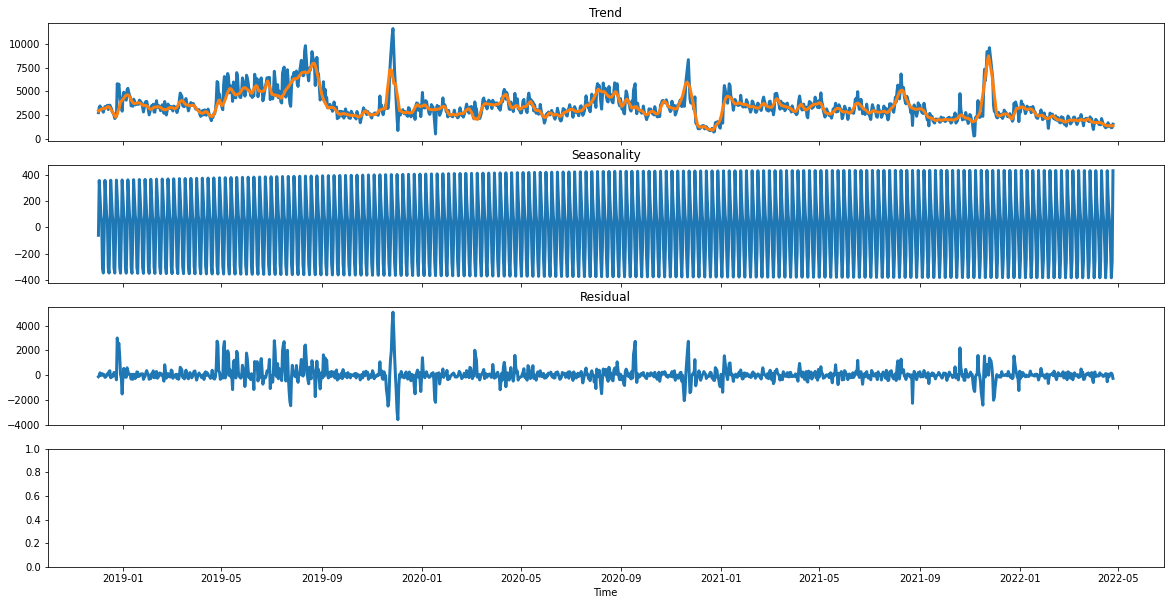

In [130]:

decomposer = TimeSeriesDecomposition(ts_outliers_interpolated, decomposition="additive", robust=True, seasonal=365)
results_outliers = decomposer.decomposer()
fig = decomposer.plot()

<AxesSubplot:>

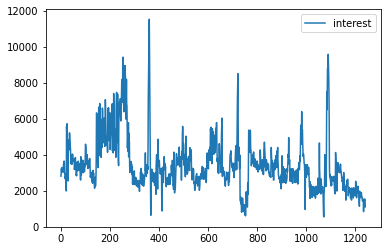

In [131]:
pd.DataFrame(results_outliers["rem"].to_dataframe()["resid"] + results_outliers["trend"].to_dataframe()["trend"], columns=["interest"])